

# Wheather Data Exploration and Analysis 

This notebook is dedicated to analysis and exploration of the climate data from wheather stations spread out on the state of AM/Brazil.
The data is available at [XXXXXXXXXX]() where is was queried in [XXX-XX-XX](). The data comprise a series of monthly averaged values of wheather variables which are further explained [here ----- path]() from where the most relevant attributes were extracted.

As *relevant attributes* to be considered, are those well populated in the time series, and those which also show consistent values across the many stations imported.

The basic stages this notebook goes through are:
* importing, manipulation an sorting of climate data
* analysis of most relevant climate attributes for further deeper explotation
* Clustering analysis
* Principal Component Analysis
* Seasonal Trend Decomposition Analysis (STL)

***
## **Table of Contents**
#### 1. Importing Data
1. Checking time spans on data sets
2. Selecting relevant stations for the state AM
3. Nan/NULL values
4. Aggregating data sets

#### 2. Wheather Data Analysis
1. Clustering Analysis
2. Principal Component Analysis

#### 3. Detailed Analysis of the PCA Model
1. 1st Component Coefficients
2. 2nd Component Coefficients
3. Analysis of the Seasonality

#### 4. Conclusion and Final Thoughts
***        


In [1]:
from resources.io import import_table, read_states_geometry, dump_data
from resources.plotting import *
from resources.utils import *
from resources.utils import Bootstrap
import glob
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL

---

## 1. Importing Data

Each file relates to wheather data recorded at one station. Data waas gathered from as many stations as possible from the north region in Brazil.


In [2]:
data_stations = [import_table(path, period='M') for path in glob.glob('./data/stations/*.csv')]
print('Total: ', len(data_stations))

./data/stations\dados_82024_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82029_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82042_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82047_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82067_M_1998-01-01_2020-01-30.csv read... Data collected successifully
./data/stations\dados_82098_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82106_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82113_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82141_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82145_M_1998-01-01_2020-09-29.csv read... Data collected successifully
./data/stations\dados_82178_M_1998-01-01_2020-09-29.csv read... Data c

Prior to data wrangling and data exploration the stations from the bulk will gradually be filtered in oorder to narrow them down to those which fit the requirements for this study.
* Same time span (starting and ending year)
* Representative of the region in analysis
* Enough observed data

 ### 1.1. Checking Time Spans on the Datasets

In [3]:
print('> Starting Year'.upper())
print_frequency([data_stations[i]['Data'].index[0].year for i in range(len(data_stations))], title='Year')
print('> Ending Year Counts'.upper())
print_frequency([data_stations[i]['Data'].index[-1].year for i in range(len(data_stations))], title='Year')

> STARTING YEAR
      Year      # of instances
------------------------------
      1998                  45

> ENDING YEAR COUNTS
      Year      # of instances
------------------------------
      2020                  41
      2016                   3
      2008                   1



In [4]:
# filtering out stations with incomplete data
data_stations = list(filter(lambda x: x['Data'].index[-1].year >= 2020, data_stations))
print('# of stations:', len(data_stations))

# of stations: 41


### 1.2. Selecting relevant Stations for the State AM

On this section the task of selecting the stations who belongs to the state of AM is carreid out.

First, the geoDataFrame of the Brazil map is read and a geoSeries containing the point locations of all imported stations is created.

The stations of interest can be selected by filtering only those whose location is within the borders of the state of AM.

In [5]:
def split_description(df):
    def split_string(string):
        state, region = [s.strip() for s in string.split('/')]
        return pd.Series((state, region), index=['State', 'Region'])
    state_region = df['Description'].apply(split_string)
    return df.join(state_region)

# Importing Brazilian states json files as GeoDataFrames
states_geometry = map(lambda df: df.dissolve(by='Name'), read_states_geometry('./data/geojson/*.geojson'))
brazil_map = pd.concat(states_geometry, axis=0)

# Fixing field Description
brazil_map = brazil_map.pipe(split_description) \
                    .drop(['Description'], axis=1)

In [6]:
# Picking geometry of stations' location
stations_locs = extract_locations(data_stations, primary_key='Code')

# Filtering staitons belonging to state AM ONLY
only_AM = stations_locs.within(brazil_map.loc['AM','geometry'])
data_AM = list(filter(lambda station:station['Code'] in stations_locs[only_AM].index, data_stations))

print('# of stations:',len(data_AM))
print('All data selected?', len(data_AM) == len(stations_locs[only_AM].index))

# of stations: 13
All data selected? True


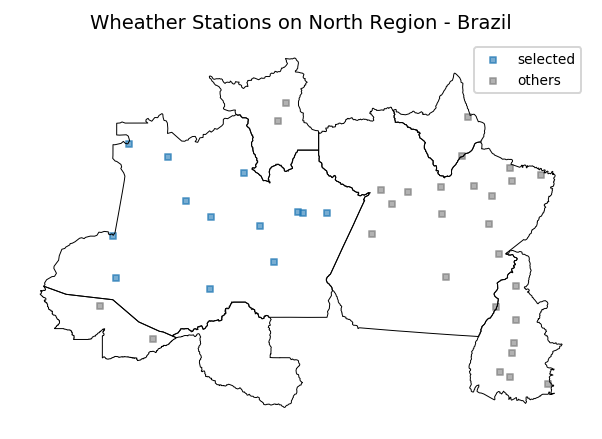

In [7]:
# plotting stations selected for the analysis

fig, ax = plt.subplots(figsize=(5,3), dpi=141, constrained_layout=True)
brazil_map[brazil_map.Region == 'NORTE'].boundary.plot(ax=ax, lw=.5, color='k')
stations_locs[only_AM].plot(ax=ax, marker='s', color='C0', label='selected', alpha=.6, markersize=11)
stations_locs[~only_AM].plot(ax=ax, marker='s', color='gray', label='others', alpha=.6, markersize=11)
ax.axis('off')
ax.legend(loc=1, fontsize=7)
ax.set_title('Wheather Stations on North Region - Brazil', fontsize=10);

At this points the following actions were taken:
* Selected Stations with data collected between 1998 and 2020
* Filtered only stations within the obrders of state AM

From the initial total of 45 stations its left 13.

### 1.3. NaN/Null values

The purpose of this section is to conceive the climate variables and stations with higher data density.
Initially a matrix whose cells show the counting of Null values throughout the period considered (1998-2020)

Later each climate variable is analysed with respect to 2 main properties

1. The sparsity: if the variable has long consecutive periods of no records
2. The dispersion: Since stations are spread out across the AM state territory, it is desired measurements that are representative of the entire state, in this case it is expected that the measurments from the many stations to **not** show dispersion.

*For this kind of evaluation of the quality of the data, a time series of each variable will plotted considering the average of the measurements along a interval band corresponding to 1-sigma of the dispersion within the measurements.*

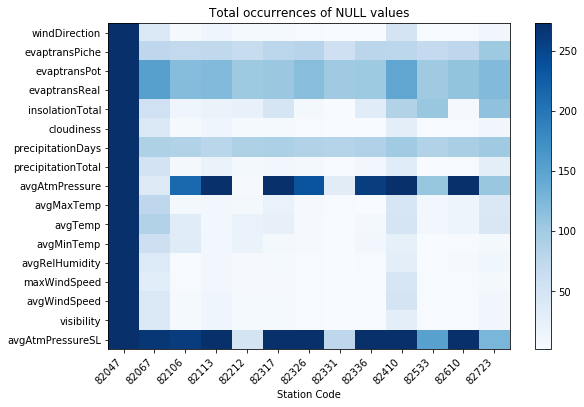

In [8]:
fig, ax = plt.subplots(figsize=(9,6))
plot_nullvalues(data_AM, ax=ax)

* Features as `avgAtmPressureSL` or `avgAtmPressure` will be discarded as they lack much of data
    * This feature could be reletaded with the *height* where the station is located, and the fire sightings dataset doesn't distinguish this aspect. So these variables could have not been of much use in any case.

* Station `820047` has any records of any features. So it will be discarded from the bulk.

In [9]:
# dropping undesired stations and features
codes_out = ['82047']
data_AM = list(filter(lambda station: station['Code'] not in codes_out, data_AM))

features = extract_fields(data_AM, exclude=['avgAtmPressure', 'avgAtmPressureSL'])
for station in data_AM:
    station['Data'] = station['Data'][features]

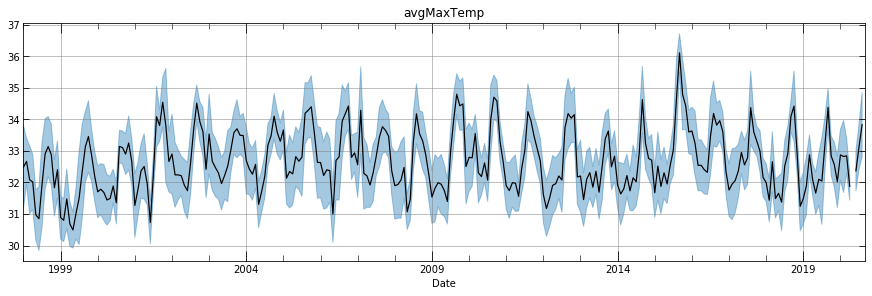

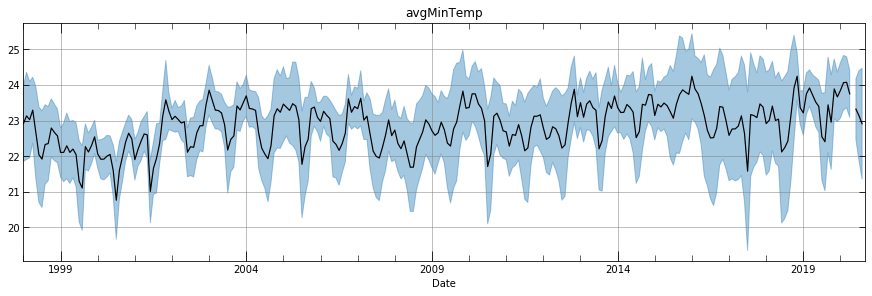

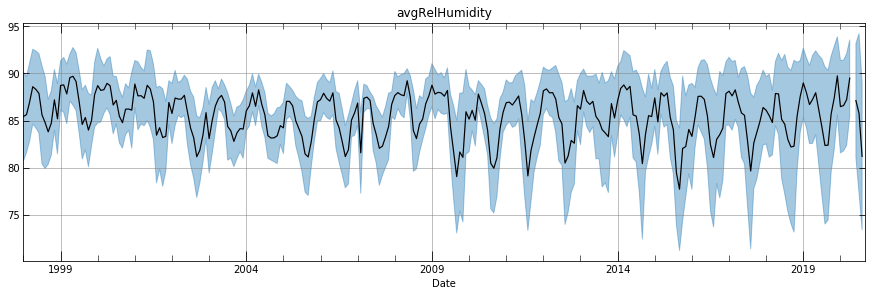

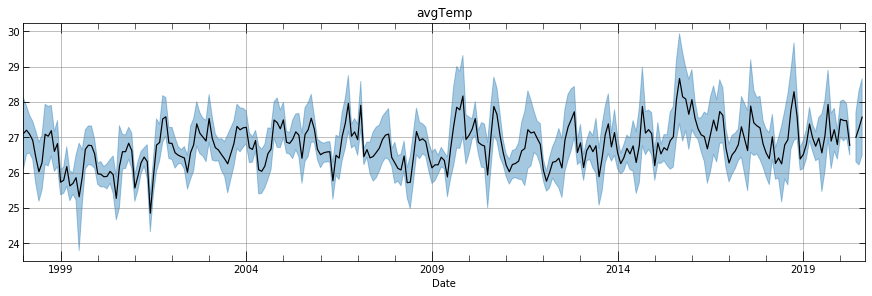

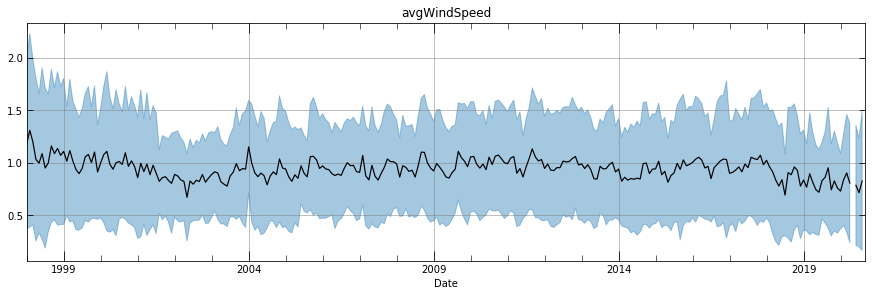

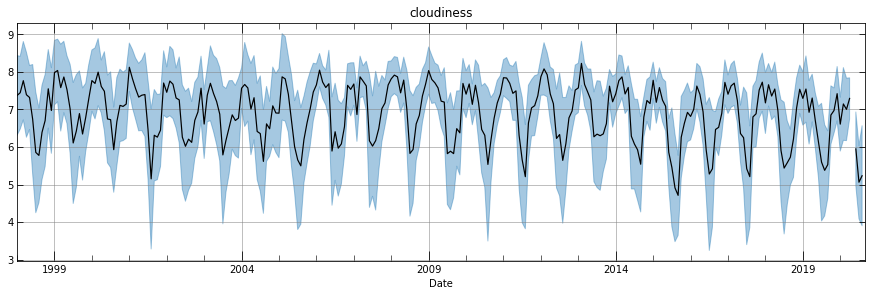

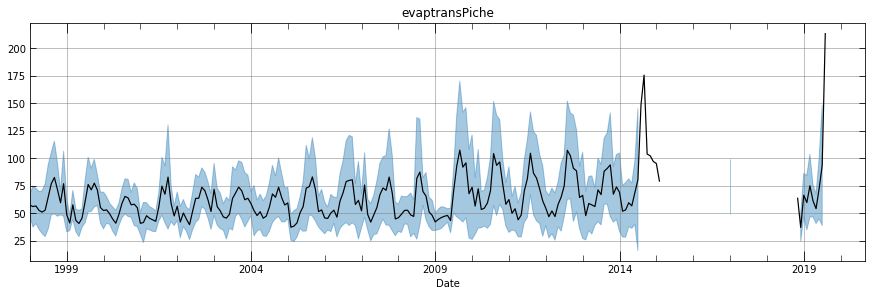

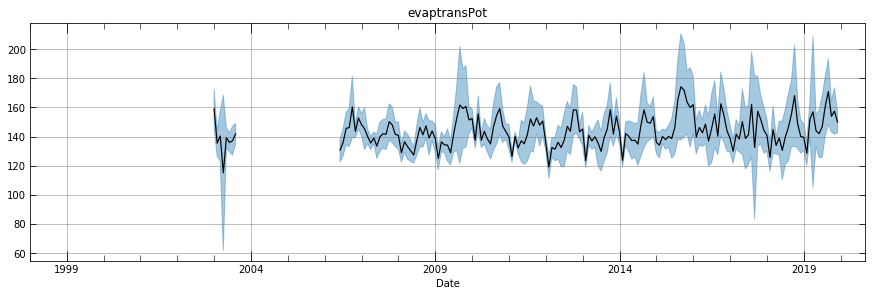

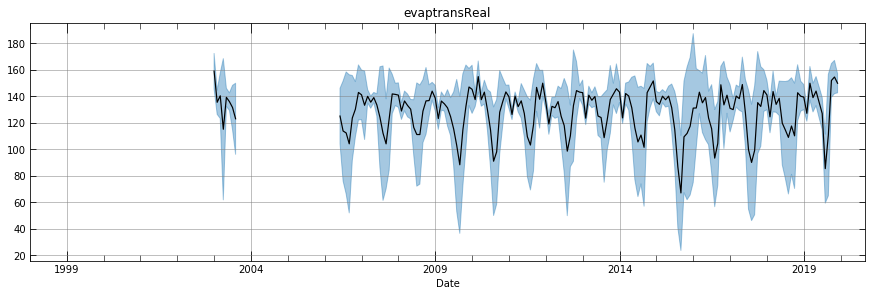

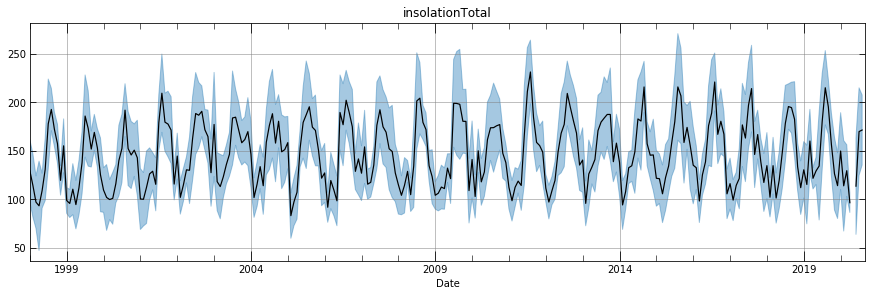

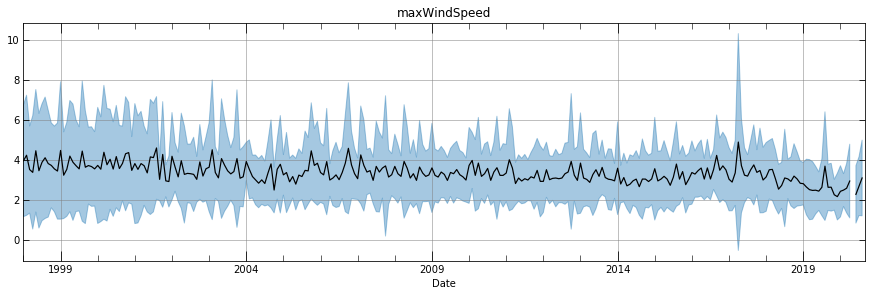

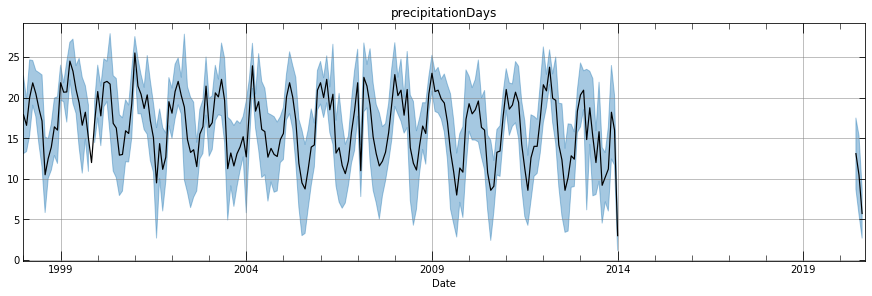

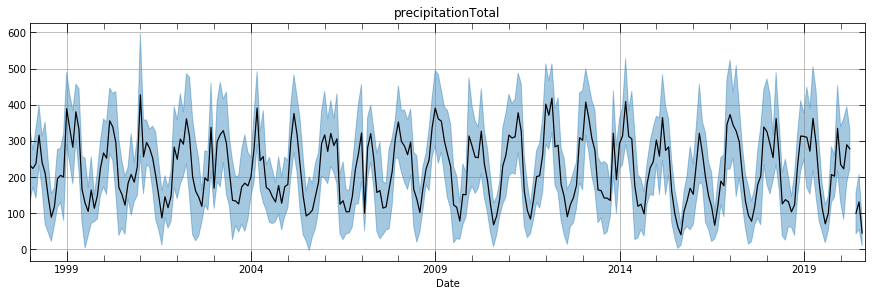

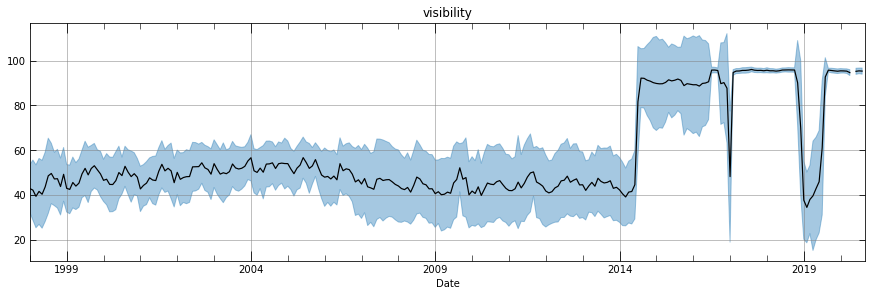

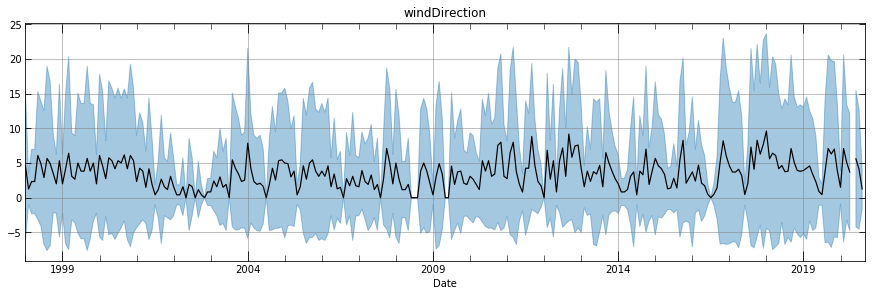

In [10]:
# Analizing time series for each `feature`
features = extract_fields(data_AM)

for feature in features:
    fig, ax = plt.subplots(figsize=(12,4), constrained_layout=True)
    data = collect_features(data_AM, feature)
    streamplot(data=data, interval='sigma', ax=ax, title=feature)

del data

Further features must be discarded once they will be either *non-informative*, *incomplete* or *inconsistent* and thefore not of much explanatory power.

* **Non-informative** are features that doesn't show relevant traces of seasonality or significant trends. Those here: `avgWindSpeed`, `maxWindSpeed`.
* **incomplete** are features which present consistently consecutive missing values across the stations. Those features are: `evaptransPiche`, `evaptransPot`, `evaptransReal` and `precipitationDays`.
* **inconsistent** features have wide dispersion around the *mean*, a strong unstructured resemblance or data seemingly poorly collected. The incosistent features considered are: `visibility`, `windDirection` and `avgMinTemp`.



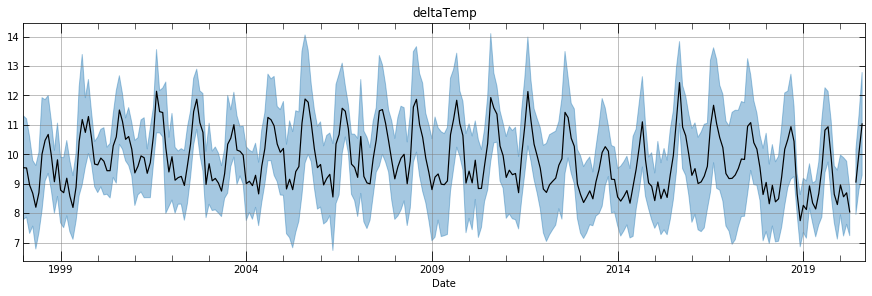

In [11]:
# Analysing the delta (deifference) of Max and Min average Temps

for station in data_AM:
    station['Data']['deltaTemp'] = station['Data']['avgMaxTemp'] - station['Data']['avgMinTemp']

deltaTemp = collect_features(data_AM, feature='deltaTemp')
fig, ax = plt.subplots(figsize=(12,4), constrained_layout=True)
streamplot(deltaTemp, interval='sigma', ax=ax, title='deltaTemp')

`deltaTemp` is the range in temperature, or the difference, between the `avgMaxTemp` and the `avgMinTemp` found in the dataset of each station in `data_station_sel`.
This feature shows seasonal properties that could be explanatory of the fire sightings in the region.

In [12]:
to_drop = ['avgWindSpeed', 'maxWindSpeed', 'evaptransPot', 'evaptransReal', 'evaptransPiche', 'visibility', 'windDirection', 'avgMinTemp', 'avgMinTemp', 'precipitationDays']

features = extract_fields(data_AM, exclude=to_drop)

### 1.4. Aggregating Datasets

On the previous stages the data has been prepared and selected in order to compose one single dataset with the representative wheather variables of the state of AM.
The next manipulations will finish this proccess by conforming all data into a single pandas DataFrame followed by the dealing with remaining NaN values.

The remanescent NaN values will be filled with the appropriated monthly averaged value.

In [13]:
# Combining all datasets based on the selected features
wheather_df = {}
for feature in features:
    wheather_df[feature] = collect_features(data_AM, feature).mean(axis=1)

wheather_df = pd.DataFrame(wheather_df)
wheather_df.head()

avgMaxTemp  avgRelHumidity    avgTemp  cloudiness  deltaTemp  \
Date                                                                    
1998-01   32.486559       85.427419  27.109560    7.370072   9.541936   
1998-02   32.664980       85.638393  27.203122    7.444445   9.532778   
1998-03   32.083578       86.970430  27.088856    7.764337   8.948387   
1998-04   32.013490       88.583868  26.914690    7.390359   8.673945   
1998-05   30.973233       88.306620  26.432407    7.317128   8.198785   

         insolationTotal  precipitationTotal  
Date                                          
1998-01       129.530000          233.291667  
1998-02       114.180000          223.925000  
1998-03        96.960000          237.250000  
1998-04        93.136364          315.883333  
1998-05       108.820000          240.350000

In [14]:
# Counting with NaN
print('NaN Values by Feature:\n')
print(wheather_df.isna().sum(axis=0))
print()
print('Dates with NULL values:')
null_indexes = wheather_df.index[wheather_df.isna().any(axis=1)]
null_indexes.strftime('%Y-%m').tolist()

NaN Values by Feature:

avgMaxTemp            2
avgRelHumidity        2
avgTemp               2
cloudiness            2
deltaTemp             2
insolationTotal       2
precipitationTotal    2
dtype: int64

Dates with NULL values:


['2020-05', '2020-09']

The NULL values are located into 2 dates: 2020-05 and 2020-09.
Since 2020-09 is the last of the dataset, it will be dropped and the remaining date will be filled with correspondent mean values for that period.

In [15]:
wheather_df = wheather_df.drop(null_indexes[-1], axis=0)
fill_values = wheather_df.groupby(wheather_df.index.month).mean()
locs_null = wheather_df.loc[wheather_df.isna().any(axis=1)].index

for loc in locs_null:
    wheather_df.loc[loc] = fill_values.loc[loc.month]

print('Any NaN Values still? ', wheather_df.isnull().any().any())

Any NaN Values still?  False


---

## 2. Wheather Data Analysis

This section starts a series of analysis with ever increasing focus in details regarding the collected data in order to uncover the main characteristics of the dynamics of the wheather in the area of interest.


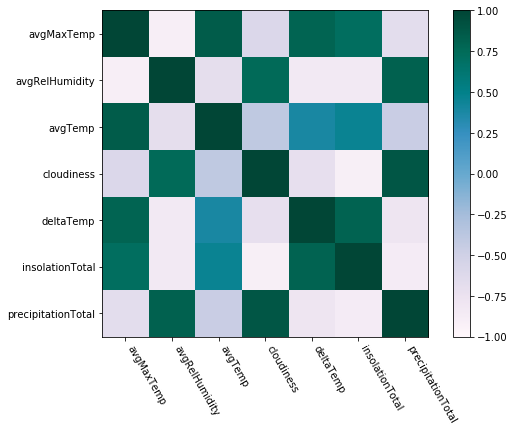

In [21]:
# displaying correlation matrix
plt.figure(figsize=(9,6))
plt.imshow(wheather_df.corr(), cmap='PuBuGn', vmin=-1, vmax=1)
plt.xticks(range(7), labels=wheather_df.columns, rotation=-60, ha='left')
plt.yticks(range(7), labels=wheather_df.columns)
plt.colorbar()

In general all variables are well correlated, whether positive or netagatively. Despite being 7 attributes analized at this points, there are only a few patterns regarding how they correlated among themselves.

## 2.1. Cluster Analysis

On *clustering* it will be sought to understand general wheather patterns in the region.
With the climate variables being high correlated, depending on how they cluster it could be possible to reveal insights and information about the local wheather.

The cluster Analysis was carried out Analysis

* Methods used involved `KMeans` and `Gaussian Mixtures`. The gaussian mixtures would have similar results when compared with kmeans, but the latter was adopted in the end as the formar seemed to overfit a little.
* As a way of measuring the quality of the clustering it was found to be appropriate analysing the clusters both by the decay of the *within sum of squares* and the *silhouette coefficient*.

In [22]:
wcss = []
silhouette_values = []
normed = StandardScaler().fit_transform(wheather_df)
normed_df = pd.DataFrame(normed, columns=wheather_df.columns, index=wheather_df.index)
for n in range(1,15):
    kmeans = KMeans(n_clusters=n, n_init=30).fit(normed)
    wcss.append(kmeans.inertia_)
    if n>1:
        silhouette_values.append(silhouette_score(normed, kmeans.labels_))

Text(0.5, 0, '# of Clusters')

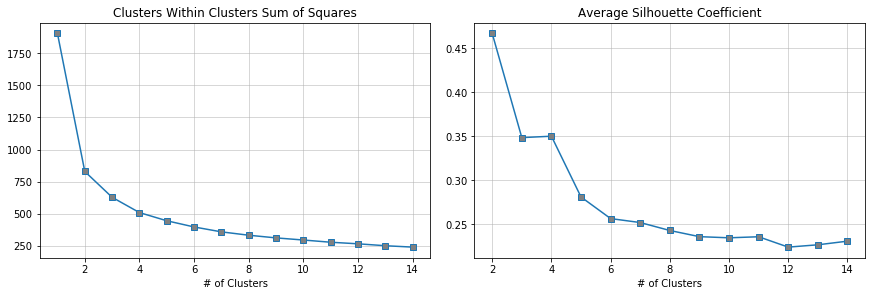

In [23]:
fig, axs = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)
axs[0].plot(range(1,15), wcss, marker='s', mfc='gray')
axs[0].set_title('Clusters Within Clusters Sum of Squares')
axs[1].plot(range(2,15), silhouette_values, marker='s', mfc='gray')
axs[1].set_title('Average Silhouette Coefficient')
axs[0].grid(lw=.5); axs[1].grid(lw=.5)
axs[0].set_xlabel('# of Clusters'); axs[1].set_xlabel('# of Clusters')

The initial diagnostic of the algorithm peformance indicates on both metrics that the *optimal number of clusters* would be **2**.

A deeper investigation is made by analyzing the distribution of the *silhouette scores* of each sample in accordance with its class (cluster).

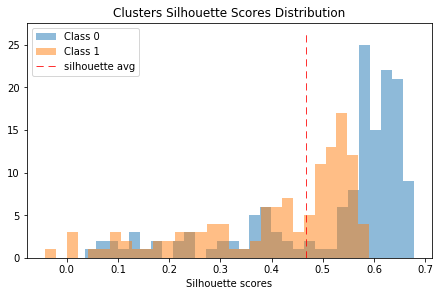

In [24]:
# the unmber of clusters chosen
n_cluster= 2

# building a KMeans model and the silhouette scores of this configuration
kmeans = KMeans(n_clusters=n_cluster, n_init=30, random_state=1111).fit(normed)
silh_avg = silhouette_score(normed, kmeans.labels_)
silh_scores = silhouette_samples(normed, kmeans.labels_)

# plotting
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
for i in range(n_cluster):
    ax.hist(silh_scores[kmeans.labels_ == i], bins=30, label='Class %d'%i, alpha=.5)
ax.vlines(silh_avg, 0, max(plt.gca().get_ylim()), ls=(0,(9, 6)), color='r', lw=.8, label='silhouette avg')
ax.set_xlabel('Silhouette scores')
ax.set_title('Clusters Silhouette Scores Distribution')
ax.legend()

The configuration of 2 clusters from the silhouette scores perspective shows a significant good result by having the bulk of the instances at the level of the average score for the whole dataset or higher.

(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text xticklabel objects>)

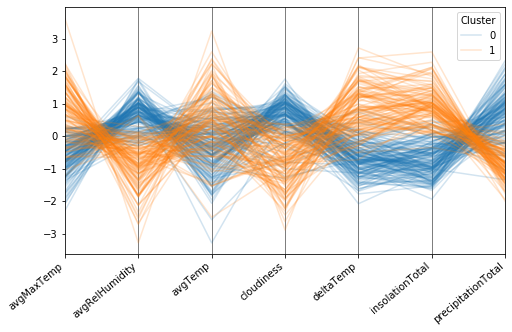

In [25]:
fig, ax = plt.subplots(figsize=(7,4.5), constrained_layout=True)

normed_df['cluster_class'] = kmeans.labels_
parallelplot(normed_df, category='cluster_class', alpha=.2, ax=ax)
plt.sca(ax); plt.xticks(rotation=40, ha='right')

The parallel (coordinates) plot reveals the main structures behind each cluster.

* The average value of each attribute with respect to each cluster is marked by a square and around these markers there are bands between the 0.5 and 0.95 percentiles. 

* On most attributes the clusters are reasonable well distinguished and their bands doesn't overlap much. It isn't the case of the `avgTemp` amd `cloudiness` though.

* The relation between the attributes responsible for determining the overall structure of the clusters resembles the basic form they are correlated (pearson's coefficient).

#### Summary

**Cluster 0** represents a cloudy/rainy condition with above average relative humidity and relative low temperatures,

**Cluster 1** represents the exact opposite revealing relative hot and dry days with long sun exposure.


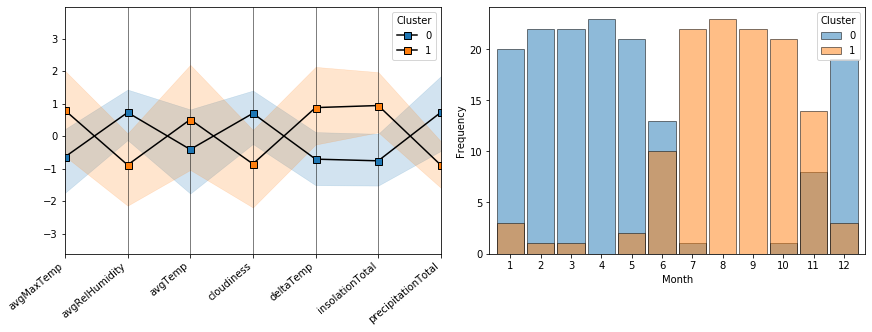

In [26]:
cluster_frequency = normed_df.assign(month=normed_df.index.month) \
                        .groupby(['month', 'cluster_class']).apply(lambda x: len(x)) \
                        .unstack('cluster_class')

fig, axs = plt.subplots(1,2, figsize=(12,4.5), constrained_layout=True)
parallelplot(normed_df, category='cluster_class', centroids=True, interval='robust', ax=axs[0], alpha=.2)

for i, cclass in enumerate([0, 1]):
    cluster_frequency[cclass].plot(kind='bar', alpha=.5, width=.9, label=cclass, edgecolor='k', color='C%d'%i, ax=axs[1])

plt.sca(axs[0]); plt.xticks(rotation=40, ha='right')
plt.sca(axs[1]); plt.xticks(rotation=0)
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Frequency')
axs[1].legend(title='Cluster')
# cluster_frequency

The parallel plot on the left panel is the same plotted previously but showing the elements within each cluster
The histogram on the right panel covers all the period on which data was collected and describes the counts of records on each month groupbed by the cluster they belong.
> This plot expands on the structure found in the data and described so far in the way that it makes clear that the clusters **have a seasonal aspect** to them.

Under these terms the hotter-drier months are mainly on the second semester with special attention to the months *july*, *august*, *september* and *october*.

According to the underlying patterns in the data is can be seen that the region under analysis has 2 basic main seasons. These will be referred from now on to as:

* Wet season (with main characteritics reflecting that of the cluster 0)
* Dry season (with main characteritics reflecting that of the cluster 1)

## 2.2. Principal Components Analysis

This analysis seeks to futher investigate and comprehend the characteristias and properties related to the wheather on the area of interest, all on top of the results already achieved.

The main guidelines for this step are:
* A basic initial analysis about whether PCA is appropriate in this dataset and if the principal components are relevant.
* In the case the dataset allows a good aproximation for the pca model, do deeper analysis on the properties of the relevant components (pca coefficients).

***

This aplication of the PCA doesn't aim *feature reduction* but explanatory insights under the patterns and cycles present in the data.

In [27]:
# Fitting the PCA model
pca = PCA().fit(normed)


Two points of interest:

* The capability of the components to *explain* the variance within the dataset.
* Development of the interpretation for the principal components.

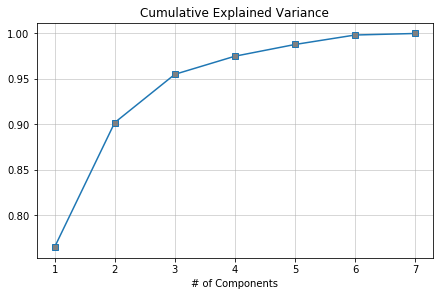

In [28]:
plt.figure(figsize=(6,4), constrained_layout=True)
plt.plot(range(1,len(features)+1), pca.explained_variance_ratio_.cumsum(), marker='s', mfc='grey')
plt.xlabel('# of Components')
plt.title('Cumulative Explained Variance')
plt.grid(lw=.5)

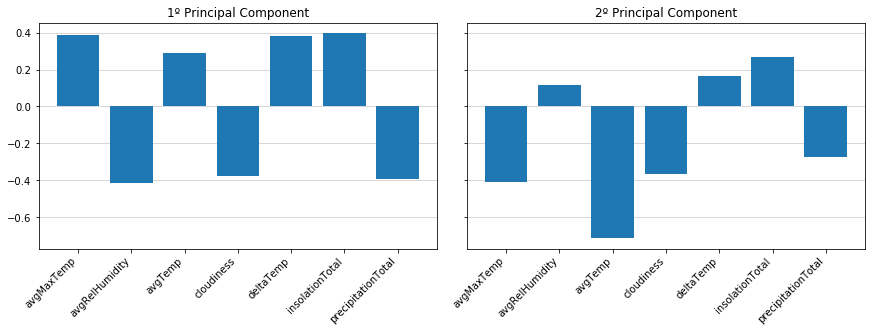

In [31]:
fig, axs = plt.subplots(1,2, figsize=(12,4.5), sharey=True, constrained_layout=True)
for i, ax in enumerate(axs):
    ax.bar(x=wheather_df.columns, height=pca.components_[i], zorder=2)
    ax.grid(axis='y', lw=.5)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{i+1}º Principal Component')

The principal analysis fitted rather well the data, being the *1st components* able to explain nearly **75%** of the variance present in the data set, and together with the *2nd component* the amount is raised up to **90%**.

These 2 first components can be considered as the main *degrees of freedom* present in the system composed of the wheather variables measured on the area covered by the stations used so far. The remaining components only contribute marginally and will not be considered in the following steps.

### 1st Component interpretation

This component captures primarly the same information analysed previously on the *clustering*. In short terms, A **positive** value for this components is related to the intensity of the *dry season* while the **negative values** have the same effect but with respect to the *wet season*.

### 2nd Component interpretation

This component has a minor impact on the measurements if compared to those of the 1st component as it responds for appr. 15% of the variance. It seems to conform characteristics of both seasons, the dry and wet: when **positive** this component reflects the same tendency found in the *dry season* with respect to the varibles `precipitationTotal`, `insolationTotal`, `deltaTemp`, `avgRelHumidity` and `cloudiness` whereas the other variabes – `avgMaxTemp`. `avgTemp`, `avgRelHumidity` – follows the tendency of the *wet season*.

So, in short, while it favors a low precipitation/cloudiness scenario, it also heavily favors lowering of the temperatures. Its **negative** values represent the exact opposite.

## 3. Detailed Analys of the PCA model

Based on the interpretation of the hidden *degrees of freedom* in the data set follows a detail exploration of the coefficient values corresponding to these degrees of freedom.

Initially a visual analysis of the time series of these coeeficients is performed.

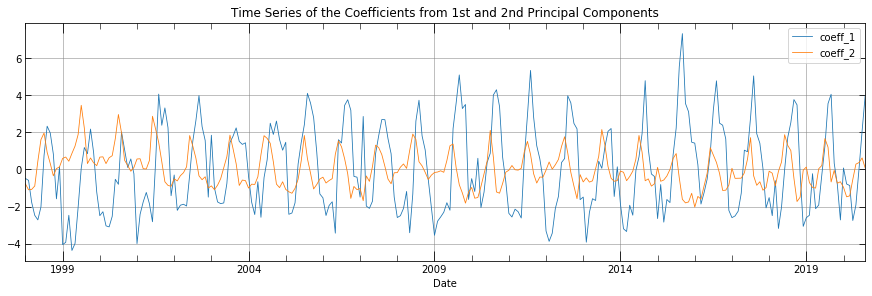

In [32]:
# casting the coefficients of the first two dof into a DataFrame
n_components = 2
coeff_df = create_df_from_pca(pca, normed, n_components)
coeff_df.index = wheather_df.index

# plotting the time series

fig, ax = plt.subplots(figsize=(12,4), constrained_layout=True)
streamplot(coeff_df, ax=ax, title='Time Series of the Coefficients from 1st and 2nd Principal Components')

* Both coefficients show an evident seasonal pattern (around 12 months) but they differ in two aspects:

    1. Amplitue - `coeff_1` has higher amplitude than `coeff_2`

    2. Phase - Their peaks and valleys are desaligned consistently which suggest a phase difference between the 2 signals.

* Both series doesn't appear to be stationary. Possibly trends and increasing variance are present.

Each *coefficient time series* of the PCA model will be analysed in detail. These analysis include

1. Seasonal-Trend Decomposition by Lowess (STL)

2. Analysis of the Trend

3. Analysis of Seasonality

***

**STL**

On each time series related to the coefficients will be applied a *trend-seasonal decomposition* in order to look for structures or patterns on each of the resulting outcomes that could further expand the understanding of the current accumulated insights about the data collected from the wheather stations.

Through this technique it could be perceveid separately how each component of the coefficient time series (trend and seasonal component) contributes for the overall PCA model.

[Coeff_1] Min Variance at period: 12
[Coeff_2] Min Variance at period: 12


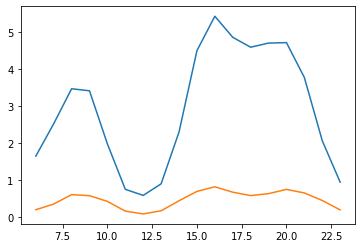

In [33]:
# Optimizing residuals for *period* parameter in STL
resid_variances = []
period_domain = range(6, 24)

for period in period_domain:
    model1 = STL(coeff_df['coeff_1'], period=period, seasonal=7).fit()
    model2 = STL(coeff_df['coeff_2'], period=period, seasonal=7).fit()
    resid_variances.append((np.var(model1.resid), np.var(model2.resid)))

resid1, resid2 = zip(*resid_variances)
plt.plot(period_domain, resid1, period_domain, resid2)

print('[Coeff_1] Min Variance at period: %d'%(min(zip(period_domain, resid1), key=lambda x:x[1])[0]))
print('[Coeff_2] Min Variance at period: %d'%(min(zip(period_domain, resid2), key=lambda x:x[1])[0]))

In [34]:
# Fitting STL model into each coefficient separetely

n_period = 12
stl_coeff_1 = STL(coeff_df['coeff_1'], period=n_period, seasonal=7).fit()
stl_coeff_2 = STL(coeff_df['coeff_2'], period=n_period, seasonal=7).fit()

**TREND** 

Beyond the STL decomposition, focusing deeply more into the *trend* aspect of the series there will be statistics tested for a 5% significance level. On this case,noticing the observed seasonal aspect, the trend considered will be that inferred from a *least squares regression* model and the confidence intervals will be taken from the quantiles of the bootstrap statistics over 2000 bootstrapped samples.

The bootstrap technique used is intended to consider the structure found in the data, so *blocks* of 12 months will be bootstrapped.

In [35]:
# subclassing the main Bootstrap object to adapt it for Block Bootstrapping

class BlockBootstrap(Bootstrap):
    def _bootstrap_data(self, *args, **kwargs):
        """Customized sampling procedure for year-based block bootstrap."""
        
        x, y = args
        x_uniq = np.unique(x)
        groups = [np.argwhere(x == x_i)[:,0] for x_i in x_uniq]
        proxies = np.arange(len(groups))
        groups_sampled = np.random.choice(proxies, size=len(groups), replace=True)
        x_bs = np.vstack(map(lambda i: x[groups[i]], groups_sampled))
        y_bs = np.vstack(map(lambda i: y[groups[i]], groups_sampled))
        return x_bs, y_bs

def get_component(df, period, i):
    """returns data of coefficient *i* as [y] related to to the values in *period* as [x]."""
    X = getattr(df.index, period).values.reshape(-1, 1)
    y = df['coeff_%s'%i].values.reshape(-1, 1)
    return X, y

**SEASONALALITY**

This analysis will take the data aggregated on the 12 month periods to get insights into how the components of the PCA model predict the dynamics of the *dry/wet* seasons detected on the are covered by the wheather stations. These components are very important as from the data it can be seen a highly strong seasonal pattern.

For that purpose, the data on this analysis should be untrended first.

In [44]:
def untrend(series, trend):
    """basic function intended to be piped in pandas Series for 
    untrending a sequence. The trend must be given."""
    
    return series - trend

### 3.1. 1st Component Coefficients

This section is aimed to understand if there is and actual relevant/significant 

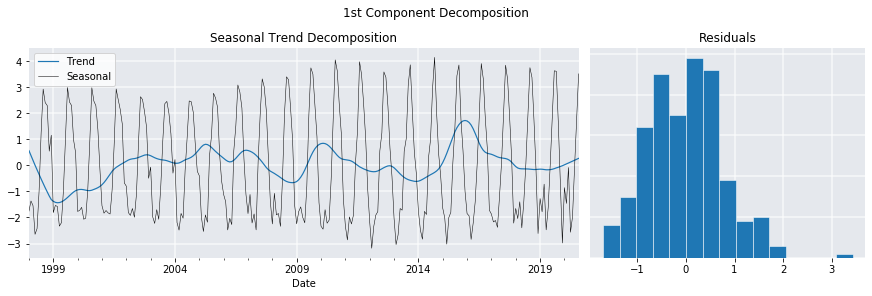

In [36]:
# Seasonal Trend deocmposition of the 1st component coefficients

decompositionplot(stl_coeff_1, title='1st Component Decomposition')

The decomposition had it value for the seasonal smoother opitmized and the residuals show a good degree of normality (with 1 likely outlier though)

The series seems to have a positive trend but still not as significant as the amplitudes of the seasonal contribution.
* *During the period covered by the gathered data* the range of values of the **trend** has appro. the same magnitude of the range of values of the **residuals** which indicates that a more in-depth analysis is necessary in order to support this evidence.

#### Trend Analysis

The analysis of trend is then extended to include the computation of the statistical interval and the autocorrelation.
* The confidence interval asserts the statistical significance of the trend. As the time series of the coefficient has a relevant seasonal component the confidence interval will be derived from *block bootstrap* sampling and the trend statistics will be the coefficient of a *ordinary least squares* regression.
    * The *blocks* in order to represent the time correlation present in the data will comprise the whole interval of 12 months, there will be then 1 block of each year of the data.

Text(0.5, 1.0, '1st Component - Trend (Linear Model)')

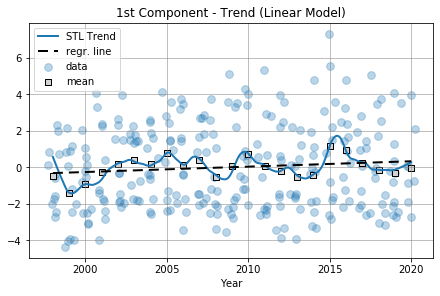

In [37]:
def jitter(x, scale=1):
    return x + np.random.normal(scale=scale, size=x.shape)

component_i = 1
X, y = coeff_df.pipe(get_component, 'year', component_i)
coeff = 'coeff_%s'%component_i

# fitting least squares regression
ols = sm.formula.ols(data=coeff_df.assign(year = coeff_df.index.year), formula='%s ~ year'%coeff).fit()

# plotting 
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True) 
ax.scatter(jitter(X, scale=.2), y, c='C0', alpha=.3, s=60, label='data')
ax.scatter(np.unique(X), coeff_df.groupby(X.ravel())[coeff].mean(), marker='s', facecolor='lightgray', s=30, edgecolor='k', label='mean')
ax.plot(np.linspace(X[0], X[-1], len(X)), stl_coeff_1.trend, label='STL Trend', color='C0', lw=2)
ax.plot(X, ols.fittedvalues, ls=(0,(5,3)), color='k', lw=2, label='regr. line')
ax.grid(lw=.5, color='gray')
ax.set_xlabel('Year')
ax.legend()
ax.set_title(f'{component_i}st Component - Trend (Linear Model)')

* the mean values on each block sampled **yearly** follows the same pattern of the trend extracted from the time series through the Lowess proccess (STL) and the regression line seems to capture a supose increase in the mean values. The bootstrapping for the statistical significance analysis is bellow

In [38]:
# confidence interval for coefficient trend (based on quantile!!!)

sig_level = 0.05 # significance level of the analysis (%95 confidence level)
bootstrap = BlockBootstrap(estimator=LinearRegression,
            attributes='coef_',
            transformation=lambda x:float(x.squeeze()),
            n_samples=2000)

bootstrap.feed(X, y, alpha=sig_level, seed=11111)
print('>>> coeff_%s Bootstrap Statistics\n>>> Confidence Level %d%%'%(component_i, int((1 - sig_level)*100)))
print('-'*65)
print(bootstrap.summary())

>>> coeff_1 Bootstrap Statistics
>>> Confidence Level 95%
-----------------------------------------------------------------
   E[stat]           Std.Error                  [0.025 --- 0.975]
     0.029               0.020                   -0.010     0.068


\* Although the SE (standard error) is in magnitude less than the estimated slope (E[stat]), assuming a null **true** slope in the data, it can't be asserted with 
95% confidence that the data presents enough evidence against this assumption.
    * This conclusion dependent on the block bootstrapping method used.
    * Its intepretation supports that the trend seen could be random and no increase in the coefficients besides the fluctations on the seasonal and residuals components is taking place, or that the collected data isn't just enought to statistically negate the assumption with 95% confidence given the method adopted and the bigger values of the seasonal fluctuations.

**Further Observations**

Since the *trend* values as in the STL decomposition have indeed magnitudes of around those within the range of the *residuals* a alternative way of detecting if there is any evidence of a significant trend in the 1st Component coefficient representing a gradual increase on its value over time will be performed.

It consists in the analysis of the itme correlation in the values of the trend and the residuals altogether. The goal is to observe if the data will show a significant tendency to trends. To that goal it will be plotted the *autocorrelation function* to observe the *memory* aspect of the timse series

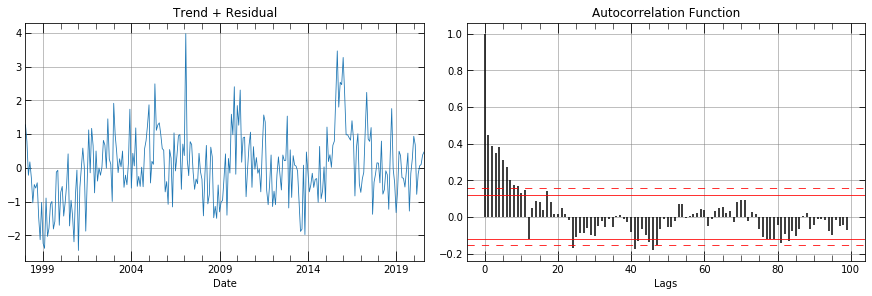

In [39]:
n_lags = 100
data = stl_coeff_1.trend + stl_coeff_1.resid

fig, axs = plt.subplots(1,2, figsize=(12,4),  constrained_layout=True)
streamplot(data, ax=axs[0], title="Trend + Residual")
autocorrplot(data, nlags=n_lags, ax=axs[1], title='Autocorrelation Function')

On the left the time series of the 1st Component coefficient values **de-seasoned** and the right the autocorrelation funtion for the first 150 lags of that same series. The red lines represents the treshold for the 5% and 1% significance levels.

* The autocorrelation function shows that the series has a consistent time correlation for the first 10 lags considering a significance level of 1% which can be considered a relevant **memory** aspect in the time series.

### 3.2. 2nd Component Coefficients

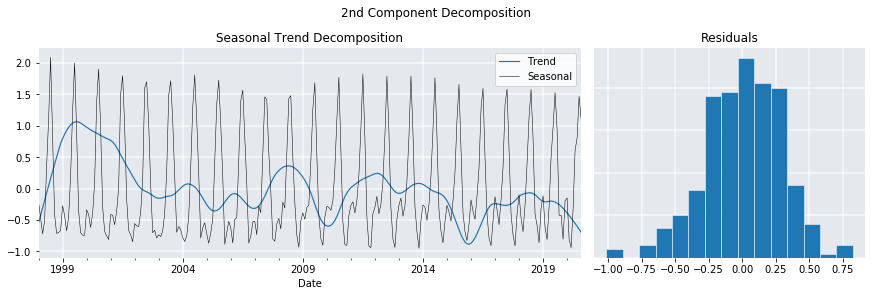

In [40]:
# Seasonal Trend deocmposition of the 2nd component coefficients

decompositionplot(stl_coeff_2, title='2nd Component Decomposition')

These coefficients share a fiew similatiries with those from the 1st component
* Trend component has a *wavy* look, specially on the second half of the time series it becomes more regular
* Seasonal trend with period of 12 months (most significant amplitudes are on this frequency)
* Residuals are seemingly symetric and normal

Some particular característics of this component are:
* Trend has a stronger rate of change apparrently, but **decreasing** in contrast with that of the 1st component
* Minor peaks rising in between the bigger peaks (it does seem to be a period phenomena on a broader timespan)
* Amplitudes of the seasonal component show an apparent decreasing tendency, evethough rather slowly.

Text(0.5, 1.0, '2st Component - Trend (Linear Model)')

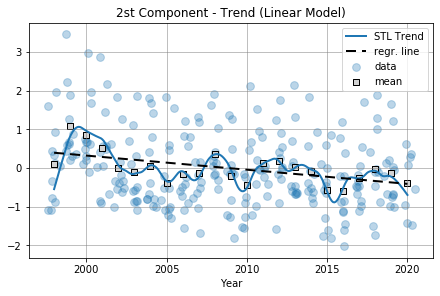

In [41]:
component_i = 2
X, y = coeff_df.pipe(get_component, 'year', component_i)
coeff = 'coeff_%s'%component_i

# fitting least squares regression
ols = sm.formula.ols(data=coeff_df.assign(year = coeff_df.index.year), formula='%s ~ year'%coeff).fit()

# plotting 
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True) 
ax.scatter(jitter(X, scale=.2), y, c='C0', alpha=.3, s=60, label='data')
ax.scatter(np.unique(X), coeff_df.groupby(X.ravel())[coeff].mean(), marker='s', facecolor='lightgray', s=30, edgecolor='k', label='mean')
ax.plot(np.linspace(X[0], X[-1], len(X)), stl_coeff_2.trend, label='STL Trend', color='C0', lw=2)
ax.plot(X, ols.fittedvalues, ls=(0,(5,3)), color='k', lw=2, label='regr. line')
ax.grid(lw=.5, color='gray')
ax.set_xlabel('Year')
ax.legend()
ax.set_title(f'{component_i}st Component - Trend (Linear Model)')

In [42]:
# confidence interval for coefficient trend (based on quantile!!!)

sig_level = 0.01 # significance level of the analysis (99% confidence level)
bootstrap = BlockBootstrap(estimator=LinearRegression,
            attributes='coef_',
            transformation=lambda x:float(x.squeeze()),
            n_samples=2000)

bootstrap.feed(X, y, alpha=sig_level, seed=11111)
print('>>> coeff_%s Bootstrap Statistics\n>>> Confidence Level %d%%'%(component_i, int((1 - sig_level)*100)))
print('-'*65)
print(bootstrap.summary())

>>> coeff_2 Bootstrap Statistics
>>> Confidence Level 99%
-----------------------------------------------------------------
   E[stat]           Std.Error                  [0.005 --- 0.995]
    -0.036               0.012                   -0.067    -0.007


* Different from the 1st Component, for the 2nd the negative slope in the trend component of the STL decomposition could be supported by the least sqaures regression of the whole data even to the extreme of 99% of confidence level.
* The magnitude of the slope is close to that of the 1st Component.

### 3.3. Analysis of the Seasonality

On both coefficients it was observed a strong seasonality on their time series and through the STL decomposition it was found the optimum value of the period of the seasonality, which would return the higher amplitudes, the period of 12 months.

With that in hand, the data was groupped into bins, each corresponding to one month of the collected data and the analysis focus on their dynamics of this period in terms of the component they represent.

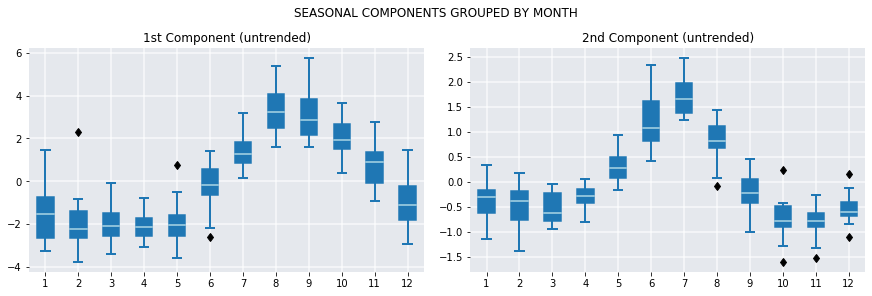

In [45]:
# binning and untrending the data (monthly basis)

trends = [stl_coeff_1.trend, stl_coeff_2.trend]
data = [coeff_df[col].pipe(untrend, trend) \
                        .groupby(coeff_df.index.month).apply(list)
                        for col, trend in zip(coeff_df.columns, trends)]

# plotting

fig, axs = plt.subplots(1, 2,  figsize=(12,4), constrained_layout=True)
fig.suptitle('Seasonal Components grouped by Month'.upper())
for i, n in zip(range(2),['1st', '2nd']):
    boxplot(data[i], ax=axs[i], patch_artist=True, title='%s Component (untrended)'%n)

* The 1st component is naturally related to the dry/wet seasons, where positive coefficients stand for the dry-hot season and negative values the wet-rainy season. This graph reveals also that the absolute values of the dry-hot season are higher than those of the wet-rainy which means from where it can be deduced that relatively speaking the hot-dry season is more intense than the other.

* The dry-hot season has peak of intensity on the months `august` and `september` whereas on the wet season the coefficients are more evenly spread.
* On months 6 and 12 the values are varying between positive and negagive values which could imply that the span of the seasons isn't always the same, in other words, there are times where the dry-hot season is **longer**.

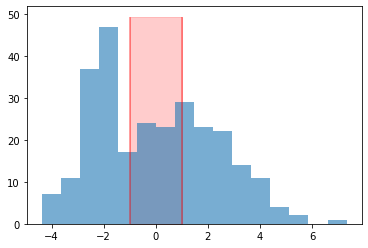

In [47]:

buffer_range = [-1, 1]
coeff_df['coeff_1'].hist(bins=16, alpha=.6)
ylim = plt.ylim()
plt.grid()
plt.vlines(buffer_range[0], *ylim, color='r', alpha=.5)
plt.vlines(buffer_range[1], *ylim, color='r', alpha=.5)
plt.fill_between(buffer_range, ylim[-1], 0, color='r', alpha=.2)

Text(0, 0.5, '# of Months')

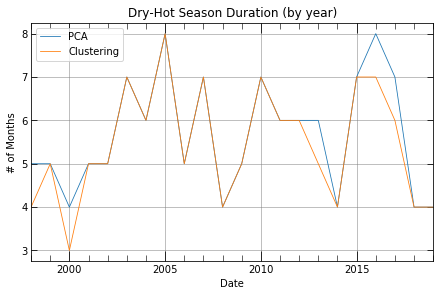

In [48]:
# Counting months on dry season period according to PCA and Clusterring models

months_dry_season = coeff_df.assign(PCA = lambda df: df.coeff_1 > 0)[['PCA']].groupby(coeff_df.index.year).sum()
months_dry_season['Clustering'] = normed_df['cluster_class'].groupby(normed_df.index.year).sum()
months_dry_season.index = pd.period_range(start=coeff_df.index[0], periods=len(months_dry_season), freq='A')

# plotting
# 2020 is dropped off since this year isnt full done regarding the when the data were queried
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)
streamplot(months_dry_season.loc[:'2019'], title='Dry-Hot Season Duration (by year)', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('# of Months')

* Both models, PCA and KMeans do agree very closely that the span of the dry-hot season. It usually varies from 4 to 7 months but ir does reach peaks of 8 months duration (on years 2005 and 2016). Important take on this aspect is that *periodically* this seasons starts prematurely as earlier as **june**.

* The 2nd Component having mixed characterístics of both dry and wet seasons, as stated before, makes sense as this component has its coeffcients more increased precisely on the transition between those 2 seasons.

* The coefficients of the 2nd Component peaks around **june/july**, just prior to the peak of the coefficients of the 1st components. Major phenomena in the dry season could be an outcome of the cojointed action of these 2 coefficients.
    * The peak of the 2nd component strength the **lowering of the precipitation** and **raising of the insolation**
    * Its negative values supports the **higher temperatures** and **lower relative humidities**. This effect takes place mostly on **september** and onwards which means that they can overlap with the high positive values of the 1st components mianly on **september and october**.

In [49]:
# processing data/models generated for output

def export_data():
    data_out = {}

    data_out['data'] = {'PCA': coeff_df}
    data_out['model'] = {'STL':{'coeff_1': stl_coeff_1, 'coeff_2': stl_coeff_2},
                        'PCA': pca,
                        'KMeans': kmeans}
    data_out['dry_season_stats'] = pd.concat([months_dry_season['PCA'].rename('dry_season_duration'),
                coeff_df.pipe(get_peak_month, field='coeff_1').rename('coeff_1_month_peak'),
                coeff_df.pipe(get_peak_month, field='coeff_2').rename('coeff_2_month_peak')],
                axis=1)
    return data_out

dump_data('wheather_data.pkl', export_data())

* * * 

## 4. Conclusions and Final Thoughts


* All data analysed in this notebook comes from wheather stations located in the state AM, which has most of its territory (if not all) in the amazon biome. The number of stations utilized was narrowed down to 13 wheather stations based on criteria supporting the integraty of the data and its power of representing the wheather conditions on its neighborhoods. So it's necessary to state that there is a **underlying assumption** that the the variance in th data is due mostly to the time aspect than to the spacial one (since the different stations are fairly distant from one another)

* The wheather variables show themselves highly correlated with one another (being the `avgTemp` the most confused) and they alternate in patterns defining baically 2 seasons on a yearly basis: a **wet-rainy** and a **dry-hot** seasons. The **dry-hot** is more **intense** (PCA analysis) and peaks at certain months.
    * The dry-hot season is characterized by high peaks in temperature, low relative humidity and low amount of precipitation having most of its days with a high level of sun exposure.
    * The wet-rainy season is characterized by a regular precipitation rate, with milder temperature and temperature range, with overall higher levels of relative humidity.

* The dry-hot season usually take place on the second semester of the year and could span through 4 (from july to october) up to 8 monhts (from june up to january) having peaks of intensity on **august/september**.

* The dry-hot season **can be preceed by unclouded and highly insolated months** that could lead to a more intense dryness on months further ahead.

* Beyond the seasonal/cyclic aspects of the variations found in the wheather variables it was found also a general **trend for higher temperatures and dryer months over time** on the period analysed (strong evidenced on the 2nd component of the PCA model and weakly evidenced on the 1st component).
    * Indeed the time series related to the variables `avgTemp`, `avgRelHimidity`, `avgMaxTemp`, `cloudiness` and `precipitationDays` do show consistent trend/variance over time supporting the result from the analysis (STL/PCA).